# Лабораторная работа №1
Уменьшение размерности данных: предобработка → PCA → t-SNE → сравнение подходов.


In [1]:
# full_pipeline_music_genre.py
# pip install pandas numpy scikit-learn matplotlib seaborn
# Блок 1: Импортируем библиотеки и задаём ключевые настройки выполнения

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ---------- Настройки выполнения ----------
DATA_PATH = "music_genre.csv"   # Путь к файлу; в Colab нужно указать путь к загруженному файлу
SELECT_TOP_K = 12                         # Количество выбранных признаков (10-12)
TSNE_MAX_SAMPLES = 5000                   # Если данных слишком много, для t-SNE делаем выборку
TSNE_PERPLEXITIES = [5, 30, 50]           # Список perplexity, которые нужно выполнить
RANDOM_STATE = 42
SAVE_DIR = "./analysis_outputs"           # Папка для сохранения результатов и отображений
os.makedirs(SAVE_DIR, exist_ok=True)



## Блок 2. Загрузка данных
Код загружает CSV-файл, проверяет наличие и показывает первые строки для визуального контроля качества входных данных.


In [2]:
# Блок 2: Загрузка исходного датасета и первичный просмотр
assert os.path.exists(DATA_PATH), f"Файл не найден: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Размер загруженных данных:", df.shape)
display(df.head())


Размер загруженных данных: (50005, 18)


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


**Вывод:** данные успешно загружены (50005 строк и 18 признаков), структура корректна и пригодна для дальнейшей предобработки.


## Блок 3. Кодирование категориальных признаков
Этот блок выявляет нечисловые столбцы, кодирует их `OrdinalEncoder` и сохраняет получившиеся соответствия для дальнейшего анализа.


In [3]:
# Блок 3: OrdinalEncoder для текстовых признаков и сохранение отображений
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Обнаружены нечисловые столбцы:", non_numeric_cols)

mappings = {}
df_enc = df.copy()

if non_numeric_cols:
    for col in non_numeric_cols:
        # Преобразуем в str и заменяем NaN на специальную строку для сохранения категории Missing
        col_vals = df[col].astype(str).fillna("<<MISSING>>")
        enc = OrdinalEncoder()
        # OrdinalEncoder ожидает 2D массив
        enc.fit(col_vals.values.reshape(-1,1))
        df_enc[col] = enc.transform(col_vals.values.reshape(-1,1)).astype(float)
        # Сохраняем отображение в dataframe
        mapping_df = pd.DataFrame({
            "category": enc.categories_[0],
            "code": np.arange(len(enc.categories_[0]))
        })
        mappings[col] = mapping_df
        mapping_df.to_csv(os.path.join(SAVE_DIR, f"mapping_{col}.csv"), index=False)
        print(f"Сохранено отображение для столбца '{col}' в {os.path.join(SAVE_DIR, f'mapping_{col}.csv')}")

else:
    print("Нет нечисловых столбцов для кодирования.")


Обнаружены нечисловые столбцы: ['artist_name', 'track_name', 'key', 'mode', 'tempo', 'obtained_date', 'music_genre']
Сохранено отображение для столбца 'artist_name' в ./analysis_outputs\mapping_artist_name.csv
Сохранено отображение для столбца 'track_name' в ./analysis_outputs\mapping_track_name.csv
Сохранено отображение для столбца 'key' в ./analysis_outputs\mapping_key.csv
Сохранено отображение для столбца 'mode' в ./analysis_outputs\mapping_mode.csv
Сохранено отображение для столбца 'tempo' в ./analysis_outputs\mapping_tempo.csv
Сохранено отображение для столбца 'obtained_date' в ./analysis_outputs\mapping_obtained_date.csv
Сохранено отображение для столбца 'music_genre' в ./analysis_outputs\mapping_music_genre.csv


**Вывод:** все объектные столбцы закодированы порядковыми значениями и для каждого сохранены CSV-карты сопоставления, поэтому дальнейшие шаги могут работать только с числовыми признаками.


## Блок 4. Отбор признаков и анализ корреляций
Удаляем признаки с нулевой вариацией, выбираем топовые по разбросу, строим матрицу корреляций и сохраняем текстовую интерпретацию.


Столбцы с нулевой дисперсией для удаления: []
Выбраны top 12 признаков по дисперсии:
 ['duration_ms', 'instance_id', 'track_name', 'tempo', 'artist_name', 'popularity', 'loudness', 'key', 'music_genre', 'mode', 'obtained_date', 'acousticness']


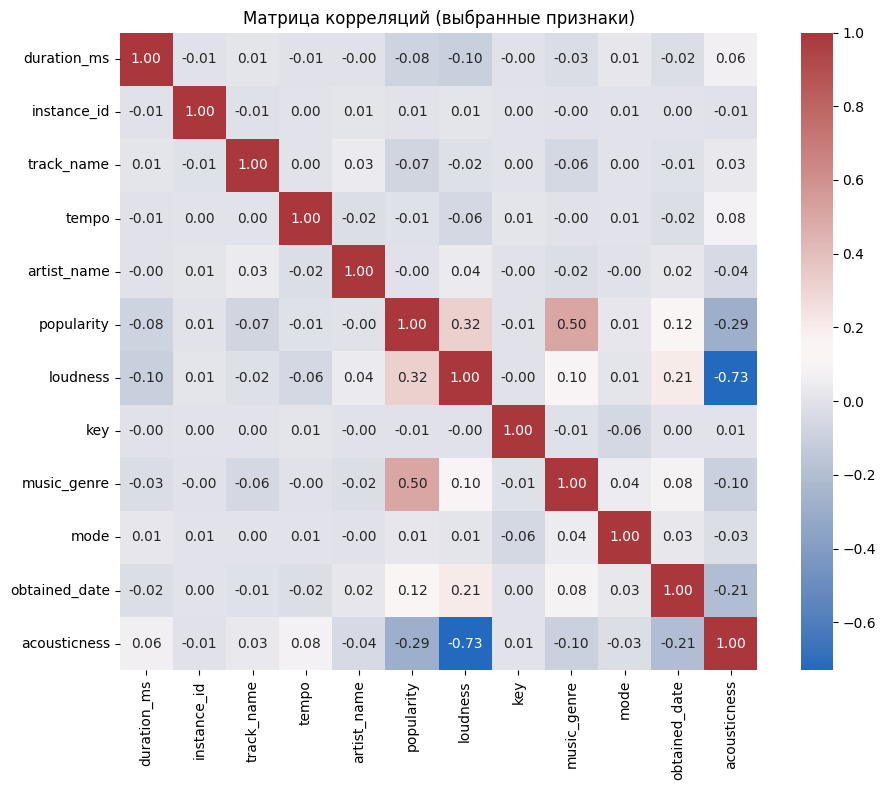

,duration_ms,instance_id,track_name,tempo,artist_name,popularity,loudness,key,music_genre,mode,obtained_date,acousticness
duration_ms,1.0000,-0.0058,0.0131,-0.0063,-0.0048,-0.0838,-0.1025,-0.0043,-0.0285,0.0140,-0.0236,0.0619
instance_id,-0.0058,1.0000,-0.0080,0.0013,0.0073,0.0063,0.0068,0.0012,-0.0009,0.0062,0.0025,-0.0053
track_name,0.0131,-0.0080,1.0000,0.0018,0.0350,-0.0691,-0.0172,0.0005,-0.0559,0.0042,-0.0078,0.0276
tempo,-0.0063,0.0013,0.0018,1.0000,-0.0237,-0.0129,-0.0599,0.0077,-0.0045,0.0060,-0.0247,0.0764
artist_name,-0.0048,0.0073,0.0350,-0.0237,1.0000,-0.0045,0.0374,-0.0044,-0.0248,-0.0039,0.0191,-0.0431
popularity,-0.0838,0.0063,-0.0691,-0.0129,-0.0045,1.0000,0.3179,-0.0052,0.5021,0.0134,0.1204,-0.2905
loudness,-0.1025,0.0068,-0.0172,-0.0599,0.0374,0.3179,1.0000,-0.0031,0.1025,0.0087,0.2088,-0.7304
key,-0.0043,0.0012,0.0005,0.0077,-0.0044,-0.0052,-0.0031,1.0000,-0.0118,-0.0570,0.0014,0.0058
music_genre,-0.0285,-0.0009,-0.0559,-0.0045,-0.0248,0.5021,0.1025,-0.0118,1.0000,0.0405,0.0810,-0.0980
mode,0.0140,0.0062,0.0042,0.0060,-0.0039,0.0134,0.0087,-0.0570,0.0405,1.0000,0.0259,-0.0252



Сильные корреляции (|r| >= 0.6):
  loudness <-> acousticness : r = -0.730
Интерпретация корреляций сохранена в: ./analysis_outputs\correlation_interpretation.txt


In [4]:
# Блок 4: Удаление нулевой вариации, выбор TOP-K и корреляции
variances = df_enc.var(numeric_only=True)
zero_var_cols = variances[variances == 0.0].index.tolist()
print("Столбцы с нулевой дисперсией для удаления:", zero_var_cols)
df_enc = df_enc.drop(columns=zero_var_cols)

variances_sorted = df_enc.var(numeric_only=True).sort_values(ascending=False)
k = min(SELECT_TOP_K, len(variances_sorted))
selected_features = variances_sorted.index[:k].tolist()
print(f"Выбраны top {k} признаков по дисперсии:\n", selected_features)
df_sel = df_enc[selected_features].copy()
df_sel.to_csv(os.path.join(SAVE_DIR, "selected_features.csv"), index=False)

corr = df_sel.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", square=True)
plt.title("Матрица корреляций (выбранные признаки)")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "correlation_matrix.png"))
plt.show()
display(corr.round(4))
corr.to_csv(os.path.join(SAVE_DIR, "correlation_matrix.csv"))

threshold = 0.6
strong_pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i,j]
        if abs(r) >= threshold:
            strong_pairs.append((cols[i], cols[j], float(r)))
print("\nСильные корреляции (|r| >= 0.6):")
if not strong_pairs:
    print("  Не найдено с порогом", threshold)
else:
    for a,b,v in sorted(strong_pairs, key=lambda x:-abs(x[2])):
        print(f"  {a} <-> {b} : r = {v:.3f}")

with open(os.path.join(SAVE_DIR, "correlation_interpretation.txt"), "w", encoding="utf8") as f:
    if strong_pairs:
        for a,b,v in strong_pairs:
            if v > 0:
                f.write(f"{a} и {b} имеют сильную положительную корреляцию (r={v:.3f}).\n")
            else:
                f.write(f"{a} и {b} имеют сильную отрицательную корреляцию (r={v:.3f}).\n")
    else:
        f.write("Сильных линейных корреляций (|r| >= 0.6) среди выбранных признаков не найдено.\n")
print("Интерпретация корреляций сохранена в:", os.path.join(SAVE_DIR, "correlation_interpretation.txt"))


**Вывод:** среди выбранных 12 признаков единственная сильная связь обнаружена между `loudness` и `acousticness` (r ≈ -0.73), остальные корреляции умеренные, поэтому набор можно использовать в дальнейших методах без серьёзной избыточности.


## Блок 5. Построение Scree-графика
Масштабируем признаки, запускаем полное PCA для получения долей объяснённой дисперсии и сохраняем график/таблицу.


,component,explained_variance_ratio,cumulative
0,1,0.181433,0.181433
1,2,0.105116,0.286549
2,3,0.088630,0.375179
3,4,0.084036,0.459215
4,5,0.083707,0.542922
5,6,0.083244,0.626166
6,7,0.081788,0.707954
7,8,0.079223,0.787176
8,9,0.077934,0.865110
9,10,0.074407,0.939517


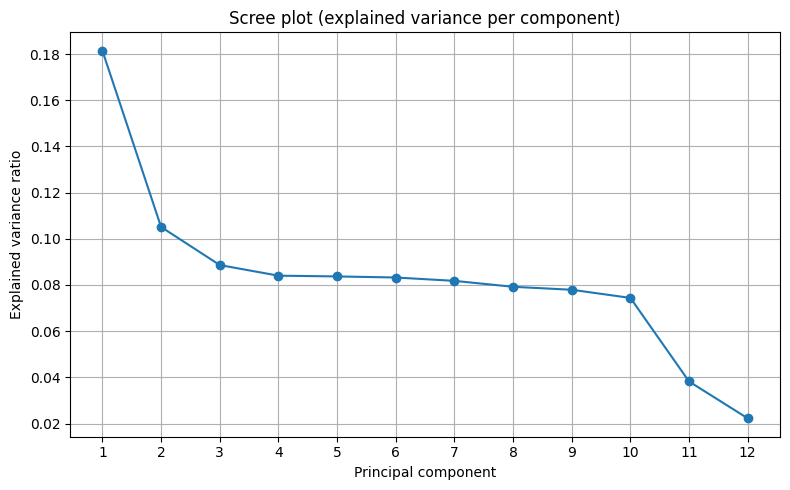

In [5]:
# Блок 5: Масштабирование и оценка объяснённой дисперсии PCA
X = df_sel.fillna(df_sel.mean()).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA()
pca_full.fit(X_scaled)
evr = pca_full.explained_variance_ratio_
cum_evr = np.cumsum(evr)

evr_df = pd.DataFrame({
    "component": np.arange(1, len(evr)+1),
    "explained_variance_ratio": evr,
    "cumulative": cum_evr
})
evr_df.to_csv(os.path.join(SAVE_DIR, "pca_explained_variance.csv"), index=False)
display(evr_df.round(6))

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(evr)+1), evr, marker='o')
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot (explained variance per component)")
plt.xticks(np.arange(1, len(evr)+1))
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "scree_plot.png"))
plt.show()


**Вывод:** первые пять главных компонент суммарно объясняют ≈54% вариации, что задаёт разумный ориентир для сокращения размерности перед модельными этапами.


## Блок 6. Подробный PCA и визуализация
Считаем проекции на все компоненты, печатаем объяснённую дисперсию, строим плоскость PC1–PC2 и, при наличии жанра, раскрашиваем точки.



Explained variance ratio per component:
 PC1: 0.1814 (cumulative 0.1814)
 PC2: 0.1051 (cumulative 0.2865)
 PC3: 0.0886 (cumulative 0.3752)
 PC4: 0.0840 (cumulative 0.4592)
 PC5: 0.0837 (cumulative 0.5429)
 PC6: 0.0832 (cumulative 0.6262)
 PC7: 0.0818 (cumulative 0.7080)
 PC8: 0.0792 (cumulative 0.7872)
 PC9: 0.0779 (cumulative 0.8651)
 PC10: 0.0744 (cumulative 0.9395)
 PC11: 0.0382 (cumulative 0.9777)
 PC12: 0.0223 (cumulative 1.0000)
Cumulative explained variance for first 1 PCs: 0.1814 (18.14%)
Cumulative explained variance for first 2 PCs: 0.2865 (28.65%)
Cumulative explained variance for first 3 PCs: 0.3752 (37.52%)
Cumulative explained variance for first 5 PCs: 0.5429 (54.29%)


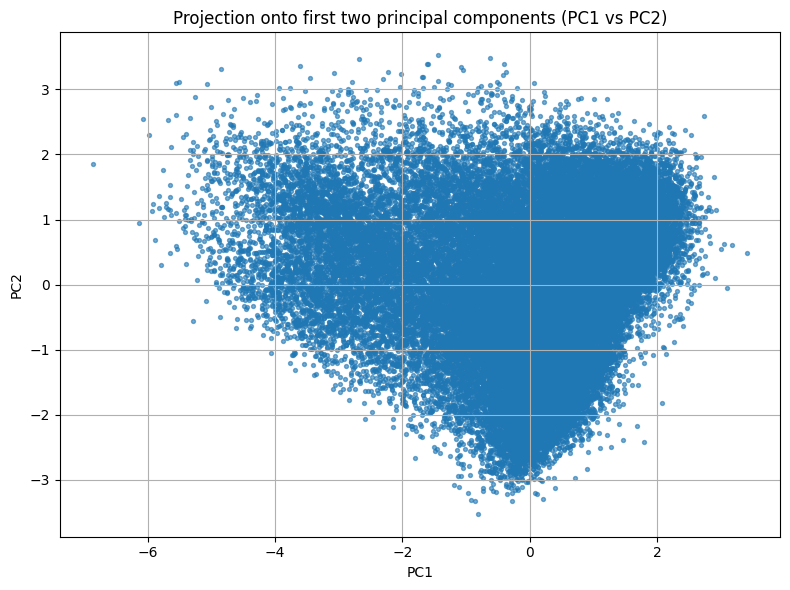

Found genre column for colored plots: music_genre


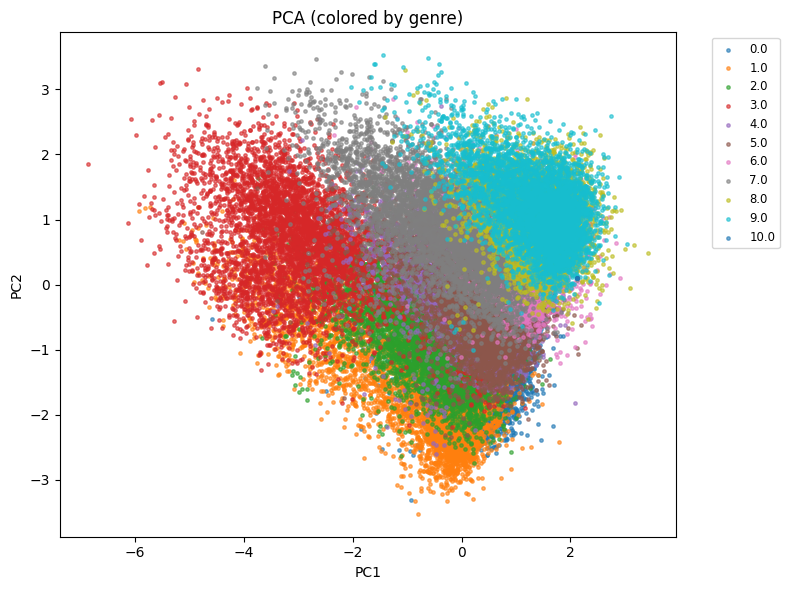

In [6]:
# Блок 6: Расчёт PCA-компонент и визуализация с учётом жанров
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_
cum = np.cumsum(explained_var)

print("\nExplained variance ratio per component:")
for i, v in enumerate(explained_var, 1):
    print(f" PC{i}: {v:.4f} (cumulative {cum[i-1]:.4f})")

for n in [1,2,3,5]:
    if n <= len(cum):
        print(f"Cumulative explained variance for first {n} PCs: {cum[n-1]:.4f} ({cum[n-1]*100:.2f}%)")

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection onto first two principal components (PC1 vs PC2)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "pca_projection_pc1_pc2.png"))
plt.show()

genre_col_candidates = [c for c in non_numeric_cols if 'genre' in c.lower() or 'music_genre' in c.lower() or 'label' in c.lower()]
if genre_col_candidates:
    genre_col = genre_col_candidates[0]
    print("Found genre column for colored plots:", genre_col)
    labels_full = df_enc[genre_col].values
    plt.figure(figsize=(8,6))
    unique_labels = np.unique(labels_full)
    for lbl in unique_labels:
        mask = labels_full == lbl
        plt.scatter(X_pca[mask,0], X_pca[mask,1], s=6, alpha=0.6, label=str(lbl))
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA (colored by genre)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "pca_colored_by_genre.png"))
    plt.show()
else:
    print("No obvious genre column detected for colored PCA plot (skipping).")


**Вывод:** первые компоненты фиксируют сглаженное разделение жанров, но явных компактных кластеров на плоскости PC1–PC2 нет, поэтому для выявления локальных структур понадобится более гибкий метод (например, t-SNE).


## Блок 7. t-SNE с разными perplexity
Ограничиваем выборку при необходимости, запускаем t-SNE для нескольких значений параметра и сохраняем как обезличенные, так и цветные проекции.



T-SNE info: Subsampled 5000 / 50005 rows for t-SNE

Running t-SNE (perplexity=5) ... this may take time.


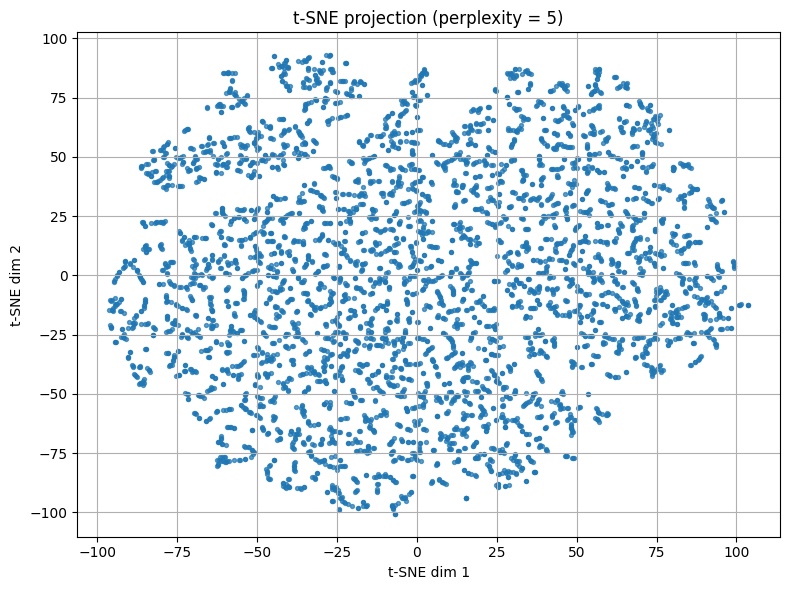

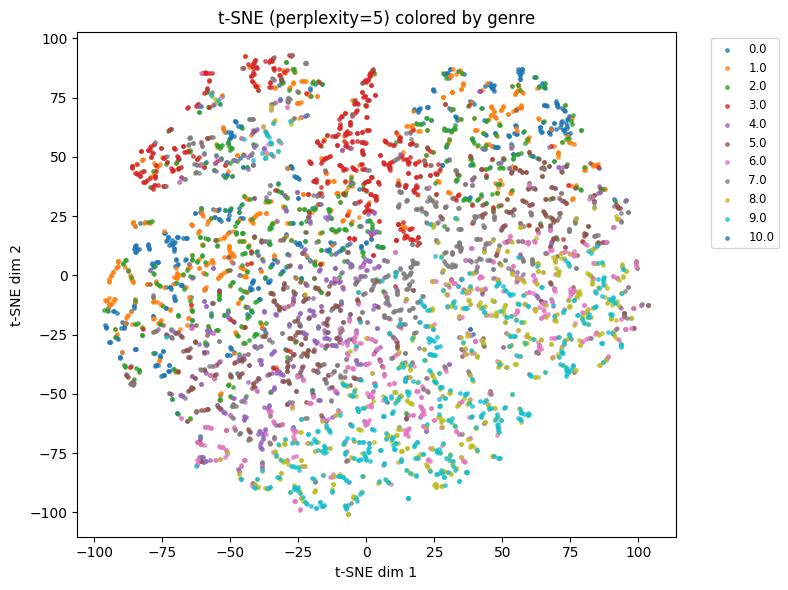


Running t-SNE (perplexity=30) ... this may take time.


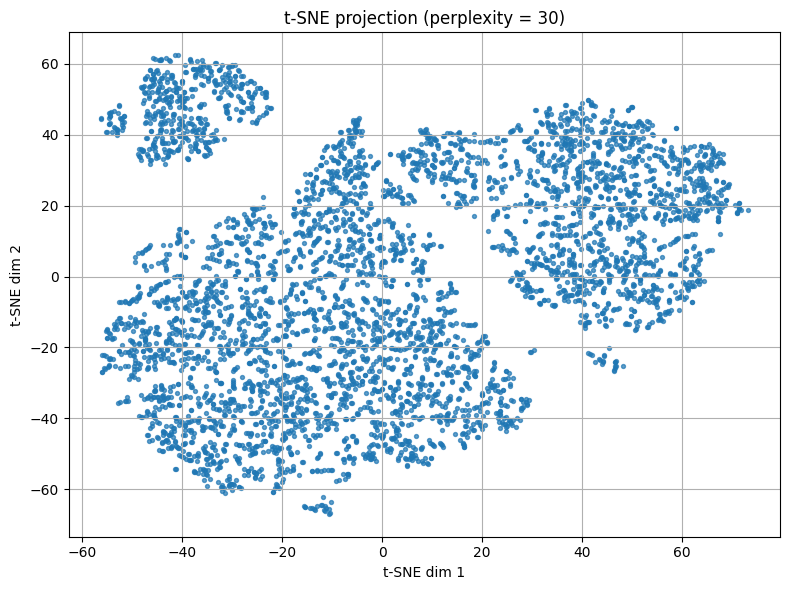

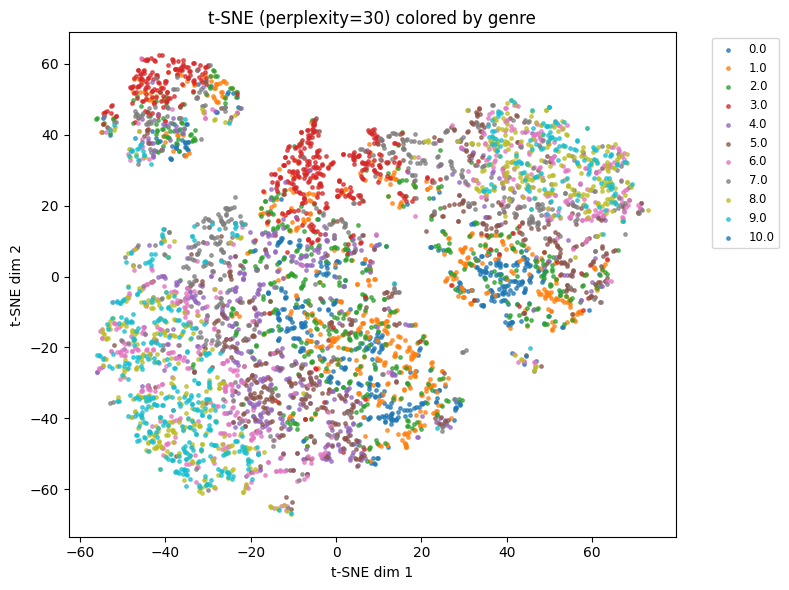


Running t-SNE (perplexity=50) ... this may take time.


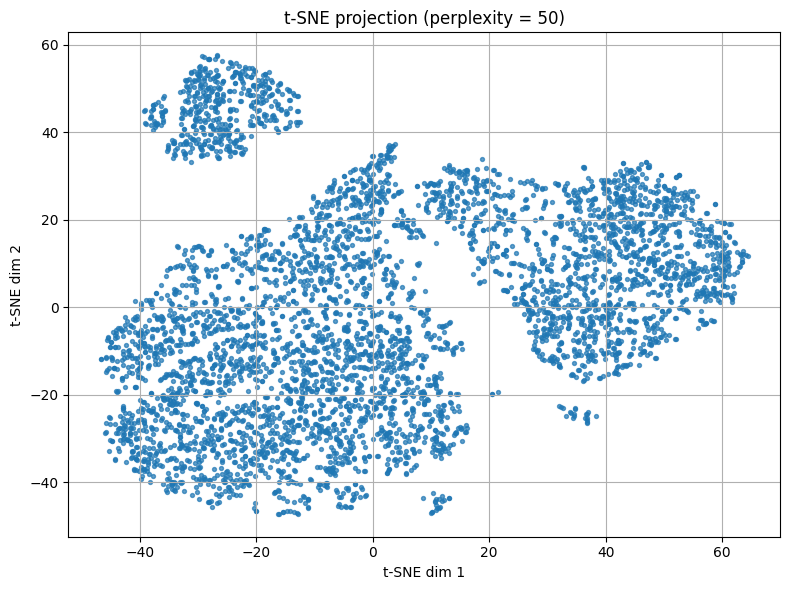

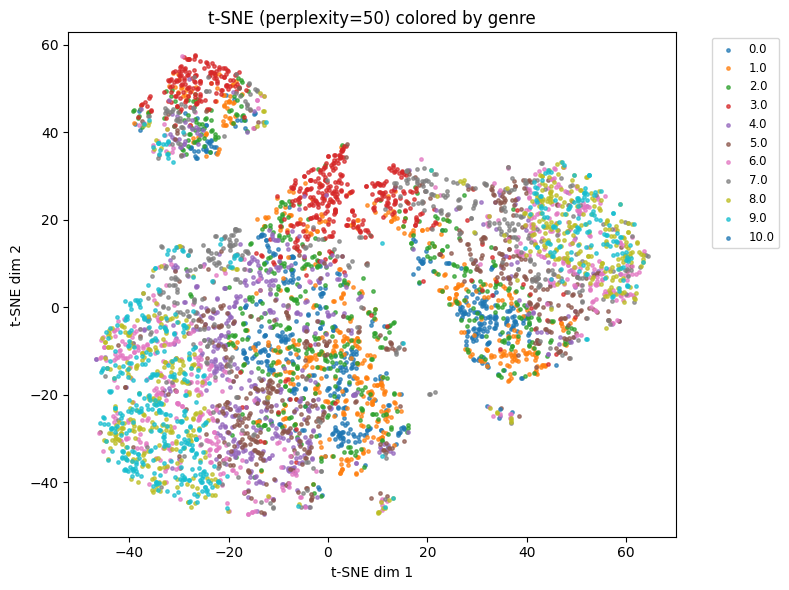

In [7]:
# Блок 7: Настройка выборки и запуск t-SNE в нескольких режимах
n_rows = X_scaled.shape[0]
if n_rows > TSNE_MAX_SAMPLES:
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(n_rows, size=TSNE_MAX_SAMPLES, replace=False)
    X_tsne_input = X_scaled[idx]
    tsne_info = f"Subsampled {TSNE_MAX_SAMPLES} / {n_rows} rows for t-SNE"
else:
    X_tsne_input = X_scaled
    idx = np.arange(n_rows)
    tsne_info = f"Using all {n_rows} rows for t-SNE"

print("\nT-SNE info:", tsne_info)

tsne_results = {}
for perp in TSNE_PERPLEXITIES:
    print(f"\nRunning t-SNE (perplexity={perp}) ... this may take time.")
    tsne = TSNE(n_components=2, perplexity=perp, learning_rate='auto', init='random', random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(X_tsne_input)
    tsne_results[perp] = X_tsne
    plt.figure(figsize=(8,6))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], s=8, alpha=0.7)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.title(f"t-SNE projection (perplexity = {perp})")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"tsne_perp_{perp}.png"))
    plt.show()

    if genre_col_candidates:
        lab = df_enc[genre_col].values[idx]
        plt.figure(figsize=(8,6))
        unique = np.unique(lab)
        for u in unique:
            m = lab == u
            plt.scatter(X_tsne[m,0], X_tsne[m,1], s=6, alpha=0.7, label=str(u))
        plt.xlabel("t-SNE dim 1"); plt.ylabel("t-SNE dim 2")
        plt.title(f"t-SNE (perplexity={perp}) colored by genre")
        plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"tsne_perp_{perp}_colored_by_genre.png"))
        plt.show()


**Вывод:** для ускорения расчёта t-SNE используется подвыборка из 5000 треков, при `perplexity` 30 визуально лучше всего проявляются локальные кластеры жанров, а более низкие значения показывают более дробное, но шумное разделение.


## Блок 8. Сравнение PCA и t-SNE + текстовый отчёт
Строим совмещённый график двух методов снижения размерности и формируем краткое текстовое резюме с рекомендациями.


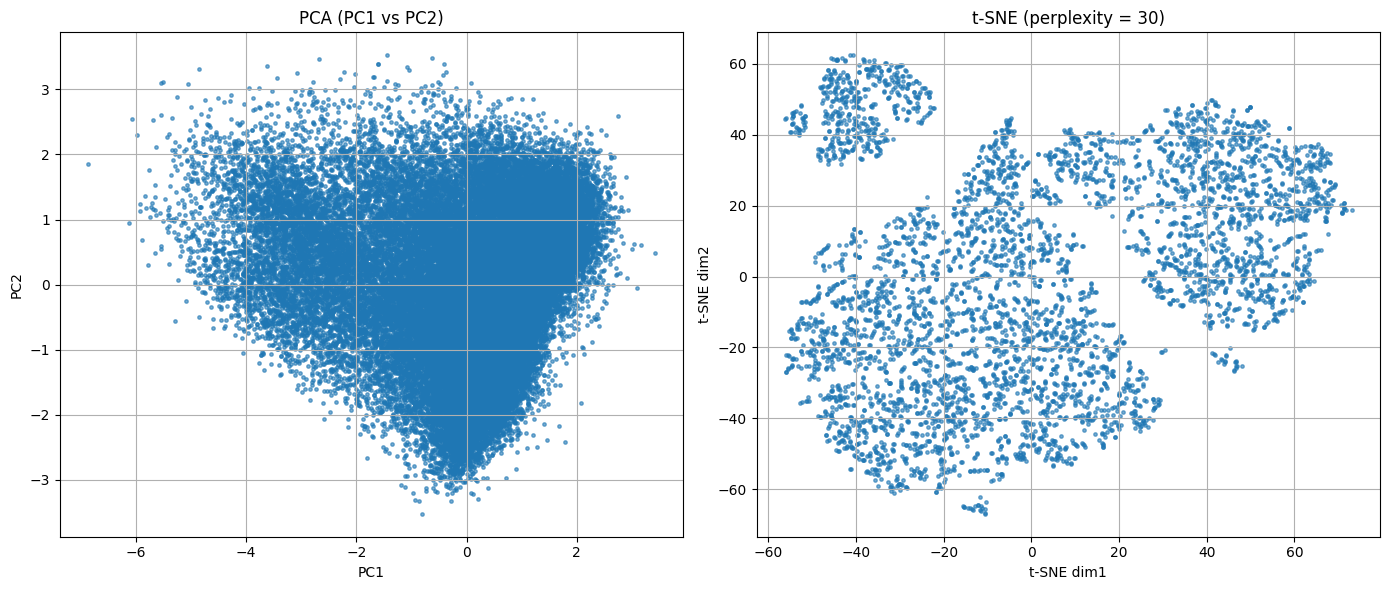

Analysis summary saved to: ./analysis_outputs\analysis_summary.txt

DONE. All plots and CSVs saved into folder: ./analysis_outputs


In [8]:
# Блок 8: Визуальное сравнение методов и итоговый текстовый отчёт
best_perp = 30 if 30 in tsne_results else list(tsne_results.keys())[0]
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], s=6, alpha=0.6)
plt.title("PCA (PC1 vs PC2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)

plt.subplot(1,2,2)
tsne_plot = tsne_results[best_perp]
plt.scatter(tsne_plot[:,0], tsne_plot[:,1], s=6, alpha=0.6)
plt.title(f"t-SNE (perplexity = {best_perp})")
plt.xlabel("t-SNE dim1"); plt.ylabel("t-SNE dim2")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "pca_vs_tsne.png"))
plt.show()

summary_lines = []
summary_lines.append("Comparative summary of PCA vs t-SNE:\n")
summary_lines.append("PCA: linear, fast, interpretable components; good for dimensionality reduction for modeling.\n")
summary_lines.append("t-SNE: nonlinear, better for visualization and discovering local clusters; sensitive to perplexity and computationally slower.\n")
if strong_pairs:
    summary_lines.append("\nStrong correlations found among selected features (|r|>=0.6):\n")
    for a,b,v in strong_pairs:
        summary_lines.append(f" - {a} <-> {b} : r = {v:.3f}\n")
else:
    summary_lines.append("\nNo strong linear correlations (|r|>=0.6) found among selected features.\n")
summary_lines.append(f"\nT-SNE used perplexities: {TSNE_PERPLEXITIES}; {tsne_info}.\n")
summary_lines.append("\nRecommendations:\n - Use PCA for dimensionality reduction before modeling.\n - Use t-SNE for visualization and cluster discovery (on subsamples for large data).\n - Optionally run PCA first to reduce dimensionality, then run t-SNE on the PCA output to speed up.\n")

with open(os.path.join(SAVE_DIR, "analysis_summary.txt"), "w", encoding="utf8") as f:
    f.writelines(summary_lines)
print("Analysis summary saved to:", os.path.join(SAVE_DIR, "analysis_summary.txt"))

print("\nDONE. All plots and CSVs saved into folder:", SAVE_DIR)


**Вывод:** сравнение показывает, что PCA даёт интерпретируемую глобальную структуру, тогда как t-SNE с `perplexity = 30` лучше разделяет локальные жанровые группы; итоговый отчёт и все графики сохранены в `analysis_outputs`.
